# Open Ocean
## Open Earth Fundation

## Step 3: 
Calculate a final number of `Marine Biodiversity Units (MBUs)` based on the modulating factors score

### Marine Biodiversity Units (MBUs)

We think that to develop a scalable system of marine biodiversity credits, we must first define what the credit unit is. To achieve this, we aim to develop a metric that incorporates the ecological values of the ecosystems within each acreage—or 1 km$^2$—of ocean protected. 

The number of MBUs assigned to each km$^2$ is modulated by different factors, which we call "Modularing Factors".

These Modulating Factors are:
1. Normalize Marine Biodiversity Score
2. Species richness
3. Species distribution area
4. Endemism
5. Habitats' Survey
6. Vulnerability of species

**Note:** Some of these factors do not have a defined methodology yet.

Each Modulating Factor has a weight factor that it's define by (...)(?)

**General Methodology**

- Per km$^2$:
$$
\begin{align}
MBUs_{sqdkm} = \sum_{i=1}^{6} C_i\times MBUs_i
\end{align}
$$

where i represent each modulating factor and $C_i$ represent the weight factor of that modulating factor

This means that each km$^2$ is assigned a number of MBUs per modulating factor

- For the entire MPA:
$$
\begin{align}
\text{Total MBUs} = \sum_{j=1}^{N} MBUs_{sqdkm}
\end{align}
$$

where N represents the total size of the MPA in km$^2$

## 3.1 Import Libraries

In [1]:
import os
import glob
import boto3

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box
from shapely.ops import linemerge, unary_union, polygonize

In [2]:
import fiona; #help(fiona.open)

**OEF Functions**

In [3]:
%load_ext autoreload

In [37]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

## 3.2 General Data Needed

**Import the entire marine protected area file**

In [5]:
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

Inspect the Coordinate Reference Systems (CRS)

In [6]:
ACMC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Grid gdf**

In [7]:
grid = create_grid(ACMC, grid_shape="hexagon", grid_size_deg=1.)

## 3.3 Calculations

### Using geometries

**Import the species information from IUCN**

In [8]:
df1 = gpd.read_file('s3://ocean-program/data/Test/gdf_range_status_filtered_shortV.shp')

In [ ]:
#Locally
#df1 = gpd.read_file('/Users/maureenfonseca/Desktop/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/gdf_range_status_filtered_shortV.shp')

The IUCN Red List dataset doesn't have information on species abundance, to calculate some MF, that information will be randomly assigned for this moment.

In [9]:
import random

fake_abundance1 = [random.randint(1, 100) for _ in range(len(df1))]
df1['abundance'] = fake_abundance1

**Import the habitats/ecosystems information**

In [ ]:
#From AWS
s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

eco_names = []

for obj in bucket.objects.filter(Prefix='data/raw/Ecosystems/'):
    name = obj.key[:]
    eco_names.append(f'https://ocean-program.s3.amazonaws.com/{name}')

In [ ]:
#Download and run it locally
# Initialize S3 client
s3 = boto3.client('s3')

# Set the name of the bucket and the path to the directory
bucket_name = 'ocean-program'
directory_path = 'data/raw/Ecosystems/'

# List all files in the directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_path)

# Download each file
for obj in response['Contents']:
    # Skip directories
    if obj['Key'].endswith('/'):
        continue
    
    # Download the file
    file_name = obj['Key'].split('/')[-1]
    s3.download_file(bucket_name, obj['Key'], file_name)
    print(f"Downloaded file: {file_name}")

The downloaded files will be saved in the current working directory, so to list it:

In [ ]:
source_dir = './'
eco_names = np.sort(glob.glob(source_dir + "/*.json"))

In [10]:
#Locally
source_dir = '/Users/maureenfonseca/Desktop/Data-Oceans/Ecosystem_Typology_IUCN/'
eco_names = np.sort(glob.glob(source_dir + "/*.json"))

**Weighted Factors**

(To be define)

### 3.3.1 Indices and metrics

**Shannon Index**

In [11]:
%%time
shannon = shannon(ACMC, df1, grid, 'abundance', 'IUCN')

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 3.72 s, sys: 91 ms, total: 3.81 s
Wall time: 3.83 s


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

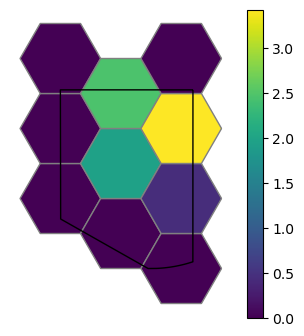

In [12]:
ax = shannon.plot(column='shannon', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

**Simpson Index**

In [13]:
%%time
simpson = simpson(ACMC, df1, grid, 'abundance', 'IUCN')

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


CPU times: user 3.64 s, sys: 19.4 ms, total: 3.66 s
Wall time: 3.66 s


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

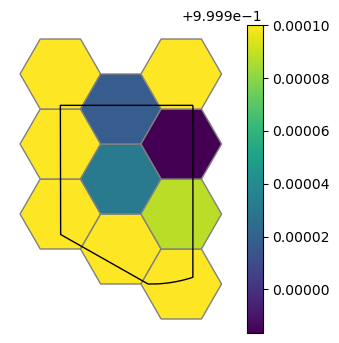

In [14]:
ax = simpson.plot(column='simpson', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

**Species Richness**

In [15]:
%%time
species_richness = species_richness(ACMC, df1, grid, 'IUCN')

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:139: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:160: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


CPU times: user 5min 37s, sys: 1.25 s, total: 5min 38s
Wall time: 5min 38s


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

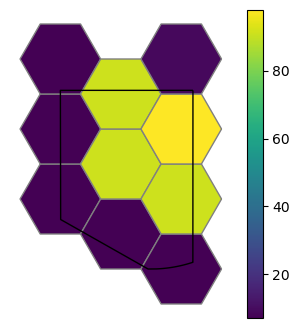

In [17]:
ax = species_richness.plot(column='species_richness', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

**Endemism**

In [18]:
%%time
endemism = endemism(ACMC, df1, grid)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:535: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


CPU times: user 3.67 s, sys: 140 ms, total: 3.81 s
Wall time: 3.84 s


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

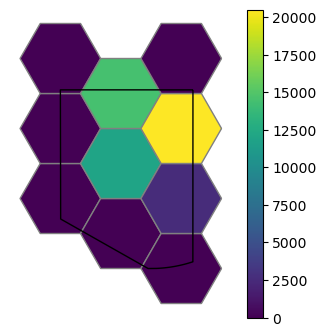

In [19]:
ax = endemism.plot(column='endemism', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

**WEGE**

In [20]:
%%time
wege = wege(ACMC, df1, grid)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:625: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roi_area = roi.area[0]
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:632: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  we = np.round(df.area/roi_area, decimals=4, out=None)
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


CPU times: user 3.71 s, sys: 36.1 ms, total: 3.74 s
Wall time: 3.75 s


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

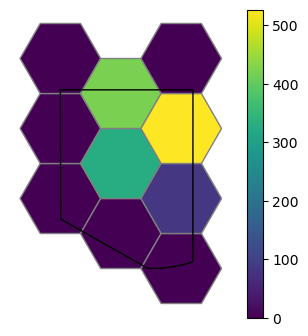

In [21]:
ax = wege.plot(column='wege', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

**Habitats Survey**

In [22]:
%%time
#This calculation is independent of the species dataset
habitats = habitats_survey(ACMC, grid, eco_names)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:139: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:160: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


CPU times: user 3min 15s, sys: 2.7 s, total: 3min 18s
Wall time: 3min 19s


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

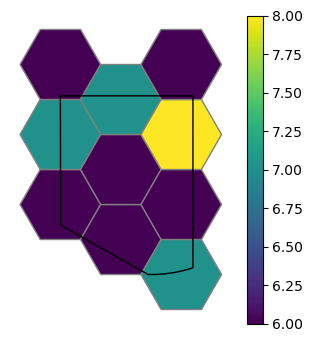

In [26]:
ax = habitats.plot(column='habitats_survey', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

### 3.3.2 Modulating Factors and MBU calculations

crs for Central America in meters: 31970

https://epsg.io/31970

**Biodiversity Score**

In [43]:
biodiversity_score_MBUS = mbu_biodiversity_score(ACMC, df1, grid, 'abundance', 'IUCN', 31970)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


In [50]:
biodiversity_score_MBUS

,area_sqkm,shannon,simpson,mbu_biodiversity_score
0,31986.471199,NaN,NaN,NaN
1,31936.727495,-0.000000,1.000000,31936.727495
2,31858.465100,-0.000000,1.000000,31858.465100
3,31751.740608,-0.000000,1.000000,31751.740608
4,31954.393897,NaN,NaN,NaN
5,31919.081068,-0.000000,1.000000,31919.081068
6,31855.354220,1.957356,0.999931,50029.250994
7,31763.257814,2.463018,0.999918,54566.215569
8,31642.856236,NaN,NaN,NaN
9,31938.178096,-0.000000,1.000000,31938.178096


**Species Richness**

In [46]:
species_richness_MBUS = mbu_species_richness(ACMC, df1, grid, 'IUCN', 31970)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:139: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:160: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


**Endemism**

In [47]:
endemism_MBUS = mbu_endemism(ACMC, df1, grid, 31970)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:535: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


**Wege**

In [48]:
wege_MBUS = mbu_wege(ACMC, df1, grid, 31970)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:625: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roi_area = roi.area[0]
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:632: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  we = np.round(df.area/roi_area, decimals=4, out=None)
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


**Habitats Survey**

In [49]:
habitats_survey_MBUS = mbu_habitats_survey(ACMC, grid, eco_names, 31970)

TypeError: 'GeoDataFrame' object is not callable

**Total MBUS**

In [45]:
TotalMBUS = biodiversity_score_MBUS['mbu_biodiversity_score'] + species_richness_MBUS['mbu_species_richness'] + endemism_MBUS['mbu_endemism'] + wege_MBUS['mbu_wege'] + habitats_survey_MBUS['mbu_habitats_survey']

0              NaN
1     31936.727495
2     31858.465100
3     31751.740608
4              NaN
5     31919.081068
6     50029.250994
7     54566.215569
8              NaN
9     31938.178096
10    35899.472116
11    63617.816988
12    31705.095832
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
Name: mbu_biodiversity_score, dtype: float64

In [ ]:
ax = mbu_habitats_survey.plot(column='TotalMBUS', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

### Using Observation Points

**Import species data from OBIS**

In [ ]:
from pyobis import occurrences

In [ ]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

query = occurrences.search(geometry=geometry)
query.execute()

# Returns the data
df2 = query.data 

The OBIS dataset doesn't have information on species abundance, to calculate some MF, that information will be randomly assigned for this moment.

In [ ]:
import random

fake_abundance2 = [random.randint(1, 100) for _ in range(len(df2))]
df2['abundance'] = fake_abundance2

### 3.3.1 Indices and Metrics

**Shannon Index**

In [ ]:
%%time
shannon = shannon(ACMC, df2, grid, 'abundance', 'obis')

**Simpson Index**

In [ ]:
%%time
simpson = simpson(ACMC, df2, grid, 'abundance', 'obis')

**Species Richness**

In [ ]:
%%time
species_richness = species_richness(ACMC, df2, grid, 'obis')

### Modulating Factors and MBU calculations

crs for Central America in meters: 31970

https://epsg.io/31970

**Biodiversity Score**

In [ ]:
mbu_biodiversity_score = mbu_biodiversity_score(ACMC, df2, grid, 'abundance', 'obis', 31970)

**Species Richness**

In [ ]:
mbu_species_richness = mbu_species_richness(ACMC, df2, grid, 'obis', 31970)